<a href="https://colab.research.google.com/github/kareembadrsaber/electropi.ai_projects/blob/master/Medical_Image_Analysis_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:27<00:00, 87.3MB/s]
100% 2.29G/2.29G [00:27<00:00, 91.1MB/s]


In [4]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


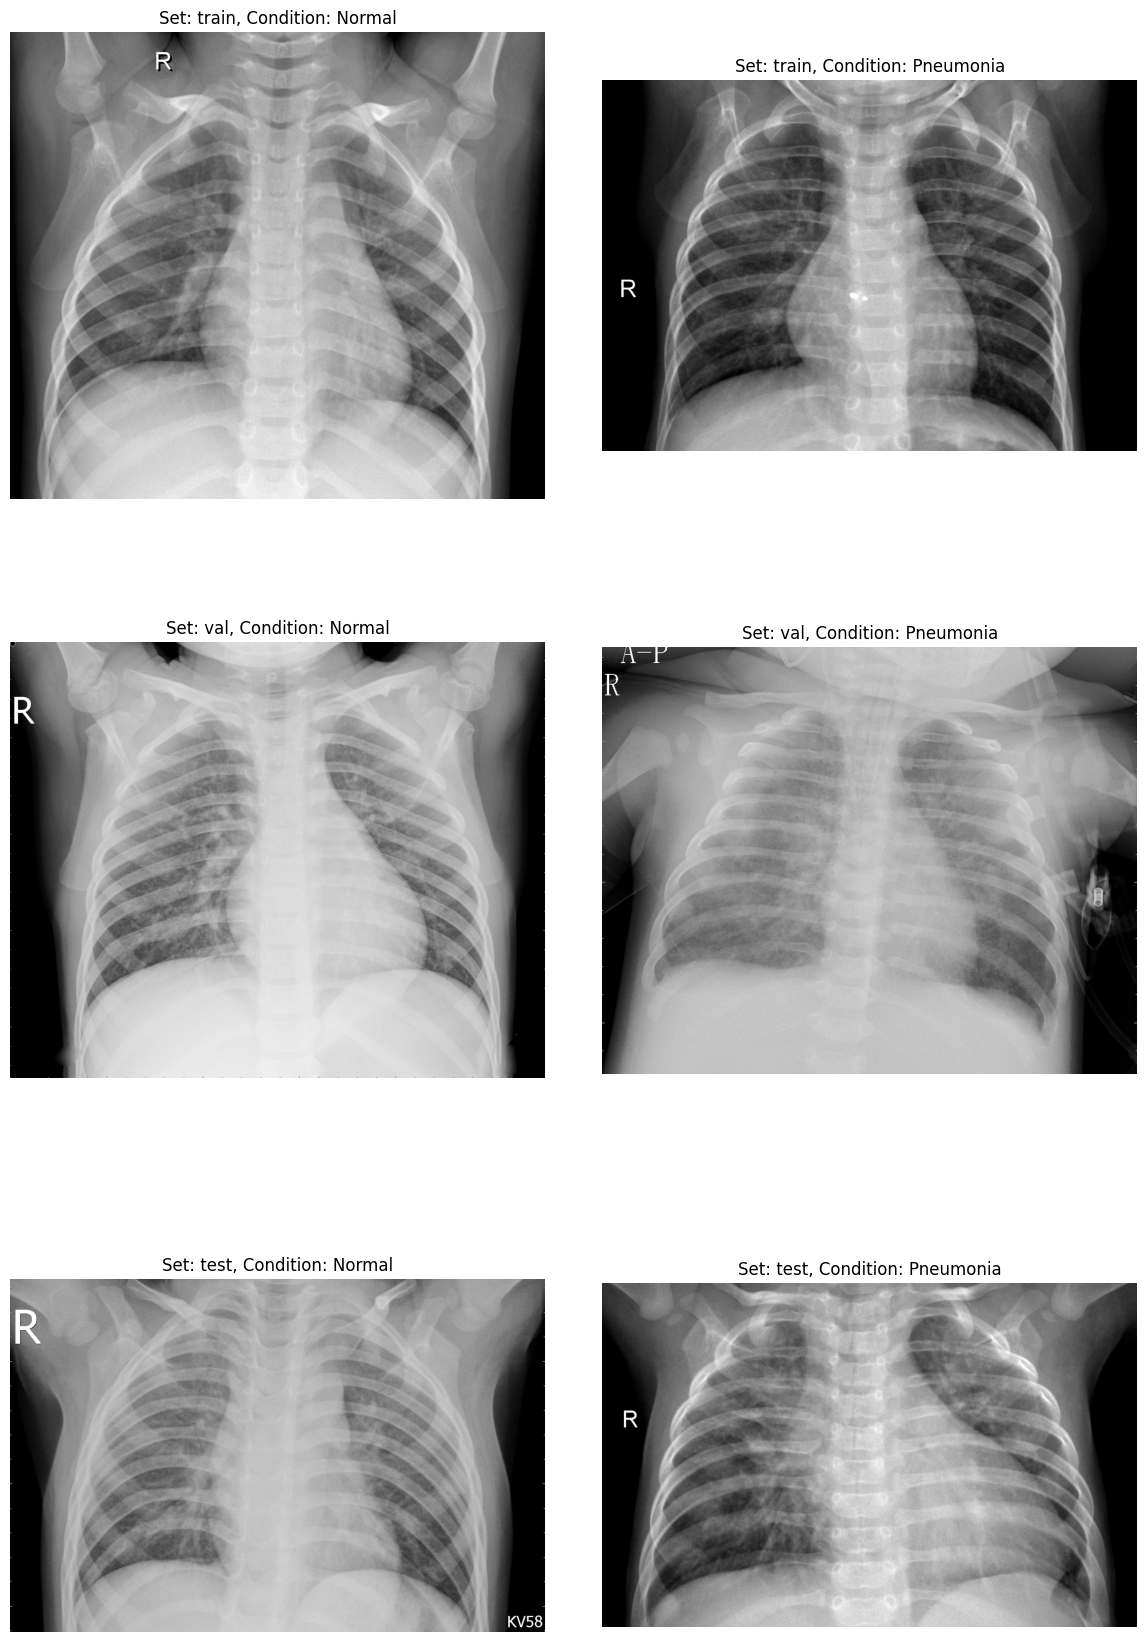

In [5]:
import os
from google.colab import files
def download_kaggle_dataset(username, dataset_name, target_dir='/content'):
    # Step 1: Upload kaggle.json
    uploaded = files.upload()

    # Step 2: Move the uploaded kaggle.json file to the appropriate directory
    os.makedirs('/root/.kaggle', exist_ok=True)
    os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

    # Step 3: Set permissions for the Kaggle API key
    !chmod 600 /root/.kaggle/kaggle.json

    # Step 4: Download the dataset from Kaggle
    download_command = f'kaggle datasets download -d {username}/{dataset_name} -p {target_dir}'
    !{download_command}

    # Step 5: Unzip the downloaded dataset
    unzip_command = f'unzip -q {target_dir}/{dataset_name}.zip -d {target_dir}/dataset'
    !{unzip_command}
def show_data(input_path):
    fig, ax = plt.subplots(3, 2, figsize=(12, 18))
    ax = ax.ravel()
    plt.tight_layout()

    for i, _set in enumerate(['train', 'val', 'test']):
        set_path = os.path.join(input_path, _set)
        normal_img_path = os.path.join(set_path, 'NORMAL', os.listdir(os.path.join(set_path, 'NORMAL'))[0])
        pneumonia_img_path = os.path.join(set_path, 'PNEUMONIA', os.listdir(os.path.join(set_path, 'PNEUMONIA'))[0])

        ax[i*2].imshow(plt.imread(normal_img_path), cmap='gray')
        ax[i*2].set_title(f'Set: {_set}, Condition: Normal')
        ax[i*2].axis('off')

        ax[i*2+1].imshow(plt.imread(pneumonia_img_path), cmap='gray')
        ax[i*2+1].set_title(f'Set: {_set}, Condition: Pneumonia')
        ax[i*2+1].axis('off')

    plt.show()

# Download the dataset
download_kaggle_dataset(username='paultimothymooney', dataset_name='chest-xray-pneumonia', target_dir='/content')

# Show data
base_dir = '/content/dataset/chest_xray'
show_data(base_dir)


In [6]:
def count_images(base_dir):
    for _set in ['train', 'val', 'test']:
        no_normal = len(os.listdir(os.path.join(base_dir, _set, 'NORMAL')))
        no_pneumonia = len(os.listdir(os.path.join(base_dir, _set, 'PNEUMONIA')))
        print(f"Set: {_set}, normal images: {no_normal}, pneumonia images: {no_pneumonia}")

# Call the function to count images
base_dir = '/content/dataset/chest_xray'
count_images(base_dir)

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
import glob
def process_data(base_dir, img_dims, batch_size):

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        zoom_range=0.3,
        vertical_flip=True,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_set = train_datagen.flow_from_directory(
        directory=os.path.join(base_dir, "train"),
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
    )

    test_set = test_datagen.flow_from_directory(
        directory=os.path.join(base_dir, "test"),
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_data = []
    test_labels = []

    for cond in ['NORMAL', 'PNEUMONIA']:
        for img_path in glob.glob(os.path.join(base_dir, 'test', cond, '*.jpeg')):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_dims, img_dims))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = img.astype(np.float32) / 255

            label = 0 if cond == 'NORMAL' else 1

            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_set, test_set, test_data, test_labels

# Call the function to process data
base_dir = '/content/dataset/chest_xray'
img_dims = 150
batch_size = 32
train_gen, test_gen, test_data, test_labels = process_data(base_dir=base_dir, img_dims=img_dims, batch_size=batch_size)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
# Extract a batch of data from the training generator
x_train, y_train = next(train_gen)

# Extract a batch of data from the test generator
x_test, y_test = next(test_gen)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

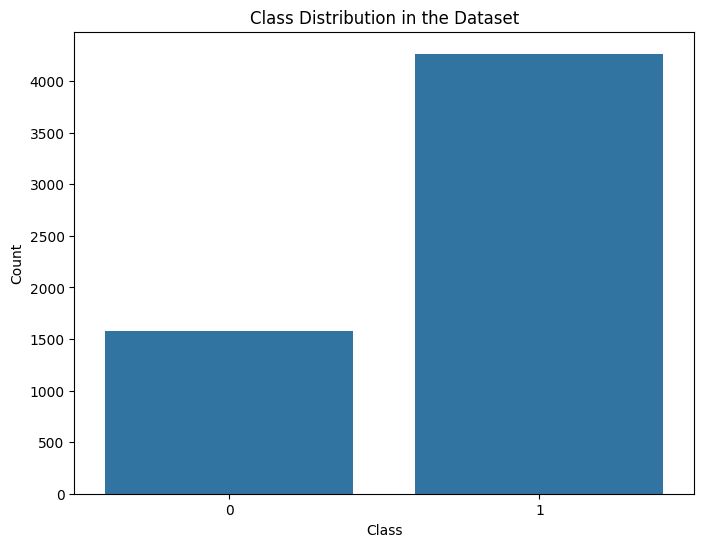

In [11]:
all_labels = np.concatenate([train_gen.classes, test_labels])
df = pd.DataFrame({"class": all_labels})

plt.figure(figsize=(8, 6))
sns.countplot(x="class", data=df)
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [12]:
from keras import models, layers, optimizers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf

In [13]:
def build_CNN_model(img_dims=150, units=128, dropout_rate=0.5):
    model = models.Sequential()
    # firrst conv block
    model.add(layers.Conv2D(filters=units,
                            kernel_size=(3,3),
                            activation='relu',
                            padding='same',
                            input_shape=(img_dims, img_dims, 3)))
    model.add(layers.Conv2D(filters=units,
                            kernel_size=(3,3),
                            activation='relu',
                            padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,3)))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units,
                           activation='relu'))
    model.add(layers.Dropout(rate=dropout_rate))

    # output layer
    model.add(layers.Dense(units=1,
                           activation='sigmoid'))

    model.compile(optimizer=optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


seed = 7
tf.random.set_seed(seed)

In [14]:
param_grid = {
    'units': [16, 32, 64],
    'dropout_rate': [0.25, 0.5],
}

In [15]:
cnn_model = KerasClassifier(build_fn=build_CNN_model,
                            img_dims=150,
                            units=32,
                            dropout_rate=0.5,
                            epochs=5,
                            batch_size=batch_size,
                            verbose=0)

cnn_model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'img_dims', 'units', 'dropout_rate', 'class_weight'])

In [16]:
random_search_cnn = RandomizedSearchCV(estimator= cnn_model,
                                       param_distributions=param_grid,
                                       cv=3)

random_search_cnn

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=32, build_fn=<function build_CNN_model at 0x780ad432e560>, dropout_rate=0.5, epochs=5, img_dims=150, units=32, verbose=0),
                   param_distributions={'dropout_rate': [0.25, 0.5],
                                        'units': [16, 32, 64]})

In [17]:
random_search_results_cnn = random_search_cnn.fit(x_train, y_train)
random_search_results_cnn

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will r

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=32, build_fn=<function build_CNN_model at 0x780ad432e560>, dropout_rate=0.5, epochs=5, img_dims=150, units=32, verbose=0),
                   param_distributions={'dropout_rate': [0.25, 0.5],
                                        'units': [16, 32, 64]})

In [18]:
pd.DataFrame(random_search_results_cnn.cv_results_)[["params"]]

,params
0,"{'units': 16, 'dropout_rate': 0.25}"
1,"{'units': 32, 'dropout_rate': 0.25}"
2,"{'units': 64, 'dropout_rate': 0.25}"
3,"{'units': 16, 'dropout_rate': 0.5}"
4,"{'units': 32, 'dropout_rate': 0.5}"
5,"{'units': 64, 'dropout_rate': 0.5}"


In [19]:
random_search_results_cnn.best_params_

{'units': 16, 'dropout_rate': 0.25}

In [20]:
round(random_search_results_cnn.best_score_*100)

81

Callbacks

In [34]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(filepath='best_model.keras',
                             save_best_only=True,
                             save_weights_only=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=2,
                              verbose=2,
                              mode='max')

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.1,
                           patience=1,
                           mode='min')

Training the Model:

In [35]:
def train_model(model, train_gen, test_gen, epochs=10, callbacks=None):
    hist = model.fit_generator(
        train_gen,
        steps_per_epoch=train_gen.samples // batch_size,
        epochs=epochs,
        validation_data=test_gen,
        validation_steps=test_gen.samples // batch_size,
        callbacks= callbacks
    )
    return hist

Displaying Metrics for trian and val set

In [36]:
def show_metrics(hist):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax = ax.ravel()
    plt.tight_layout()

    for i, metr in enumerate(['accuracy', 'loss']):
        ax[i].plot(hist.history[metr])
        ax[i].plot(hist.history['val_' + metr])
        ax[i].set_title(f'Model {metr}')
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(metr)
        ax[i].legend(['train', 'test'])

    plt.show()

Evaluation Metrics for test set


In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [38]:
def evaluate_model(model, test_data, test_labels, hist):
    preds_labels = model.predict(test_data)
    test_acc = np.round(accuracy_score(test_labels,
                                       np.round(preds_labels)) * 100, 2)
    train_acc = np.round((hist.history['accuracy'][-1] * 100, 2))[0]
    cr = classification_report(test_labels,
                               np.round(preds_labels))
    cm = confusion_matrix(test_labels,
                          np.round(preds_labels))
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    plt.show()
    return preds_labels, test_acc, train_acc, cr, cm, cmd

Test Multiple models arch and choose the best

In [39]:
def train_model(model, train_gen, test_gen, epochs=10, callbacks=None):
    hist = model.fit(
        train_gen,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=test_gen
    )
    return hist


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.7073 - loss: 0.6899 - val_accuracy: 0.6506 - val_loss: 0.6340 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.7876 - loss: 0.4345 - val_accuracy: 0.7837 - val_loss: 0.4517 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8372 - loss: 0.3783
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.8372 - loss: 0.3782 - val_accuracy: 0.7500 - val_loss: 0.4743 - learning_rate: 0.0010
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step


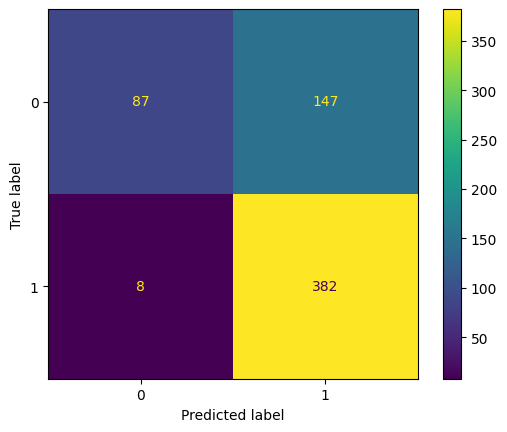

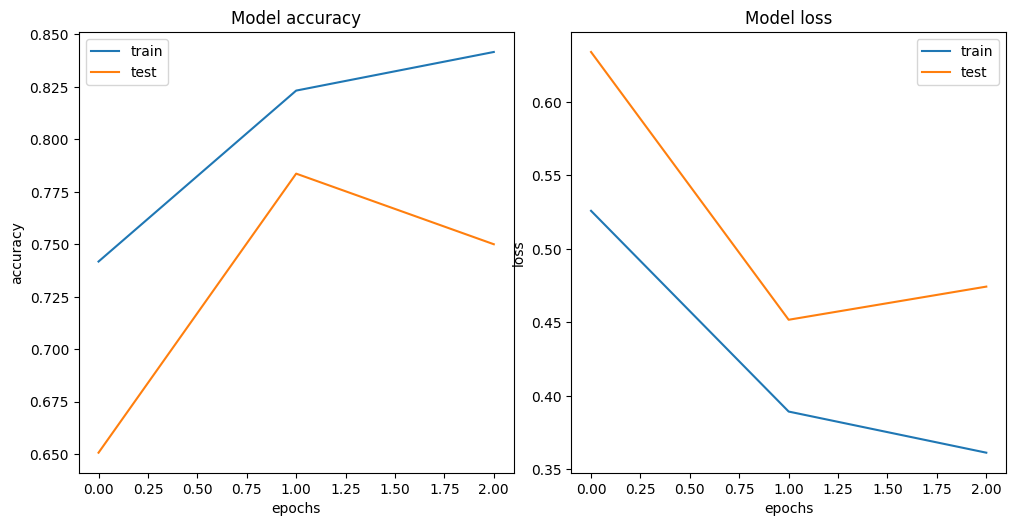

In [40]:
cnn_model = build_CNN_model(img_dims,
                            random_search_results_cnn.best_params_['units'],
                            random_search_results_cnn.best_params_['dropout_rate'])

cnn_hist = train_model(cnn_model,
                       train_gen,
                       test_gen,
                       epochs=15,
                       callbacks=[checkpoint, reduce_lr, early_stop])
cnn_preds, cnn_test_acc, cnn_train_acc, cnn_cr, cnn_cm, cnn_cmd = evaluate_model(cnn_model,
                                                                test_data,
                                                                test_labels,
                                                                cnn_hist)
show_metrics(cnn_hist)

In [41]:
print("CNN Model Classification Report:")
print(cnn_cr)

CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.37      0.53       234
           1       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.82      0.68      0.68       624
weighted avg       0.79      0.75      0.72       624

